In [2]:
!pip install xgboost

In [3]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

from sklearn.tree import DecisionTreeRegressor

from sklearn.svm import SVR

from sklearn.neighbors import KNeighborsRegressor

from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBRegressor

import pickle

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:
df = pd.read_csv('avacado.csv')
df

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0.0,27-12-2015,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015.0,Albany
1,1.0,20-12-2015,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015.0,Albany
2,2.0,13-12-2015,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015.0,Albany
3,3.0,06-12-2015,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015.0,Albany
4,4.0,29-11-2015,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015.0,Albany
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16463,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16464,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16465,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16466,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# EDA

In [6]:
df.columns

Index(['Unnamed: 0', 'Date', 'AveragePrice', 'Total Volume', '4046', '4225',
       '4770', 'Total Bags', 'Small Bags', 'Large Bags', 'XLarge Bags', 'type',
       'year', 'region'],
      dtype='object')

In [7]:
df.drop('Unnamed: 0',axis=1,inplace=True)

In [8]:
df.shape

(16468, 13)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16468 entries, 0 to 16467
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          1517 non-null   object 
 1   AveragePrice  1517 non-null   float64
 2   Total Volume  1517 non-null   float64
 3   4046          1517 non-null   float64
 4   4225          1517 non-null   float64
 5   4770          1517 non-null   float64
 6   Total Bags    1517 non-null   float64
 7   Small Bags    1517 non-null   float64
 8   Large Bags    1517 non-null   float64
 9   XLarge Bags   1517 non-null   float64
 10  type          1517 non-null   object 
 11  year          1517 non-null   float64
 12  region        1517 non-null   object 
dtypes: float64(10), object(3)
memory usage: 1.6+ MB


In [10]:
df['Date'] = pd.to_datetime(df['Date'])

In [11]:
df.describe()

,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,year
count,1517.000000,1.517000e+03,1.517000e+03,1.517000e+03,1.517000e+03,1.517000e+03,1.517000e+03,1.517000e+03,1517.000000,1517.000000
mean,1.074990,1.601879e+06,6.464387e+05,6.114375e+05,5.040550e+04,2.935974e+05,2.487736e+05,4.264205e+04,2181.771074,2015.162821
std,0.188891,4.433143e+06,1.947614e+06,1.672906e+06,1.377812e+05,7.579765e+05,6.474765e+05,1.182157e+05,7455.712144,0.369324
min,0.490000,3.875074e+04,4.677200e+02,1.783770e+03,0.000000e+00,3.311770e+03,3.311770e+03,0.000000e+00,0.000000,2015.000000
25%,0.980000,1.474700e+05,2.040034e+04,4.147606e+04,9.112500e+02,3.620689e+04,2.972722e+04,5.407400e+02,0.000000,2015.000000
50%,1.080000,4.027919e+05,8.175117e+04,1.186649e+05,7.688170e+03,7.397906e+04,6.237569e+04,5.044350e+03,0.000000,2015.000000
75%,1.190000,9.819751e+05,3.775785e+05,4.851503e+05,2.916730e+04,1.576097e+05,1.461994e+05,2.926767e+04,401.480000,2015.000000
max,1.680000,4.465546e+07,1.893304e+07,1.895648e+07,1.381516e+06,6.736304e+06,5.893642e+06,1.121076e+06,108072.790000,2016.000000


In [12]:
df.isna().sum()

Date            14951
AveragePrice    14951
Total Volume    14951
4046            14951
4225            14951
4770            14951
Total Bags      14951
Small Bags      14951
Large Bags      14951
XLarge Bags     14951
type            14951
year            14951
region          14951
dtype: int64

<AxesSubplot:>

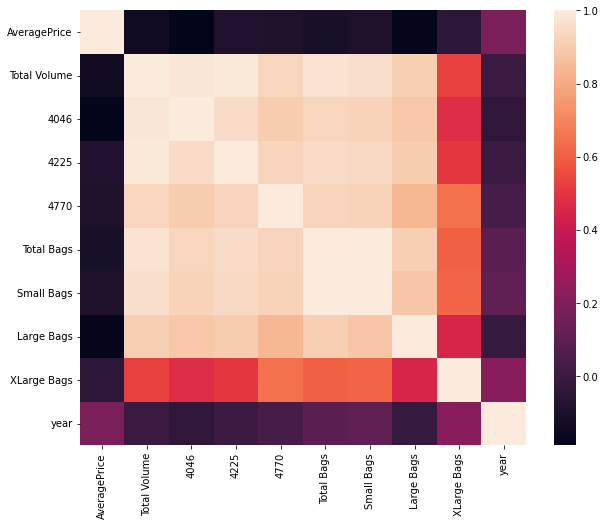

In [13]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr())

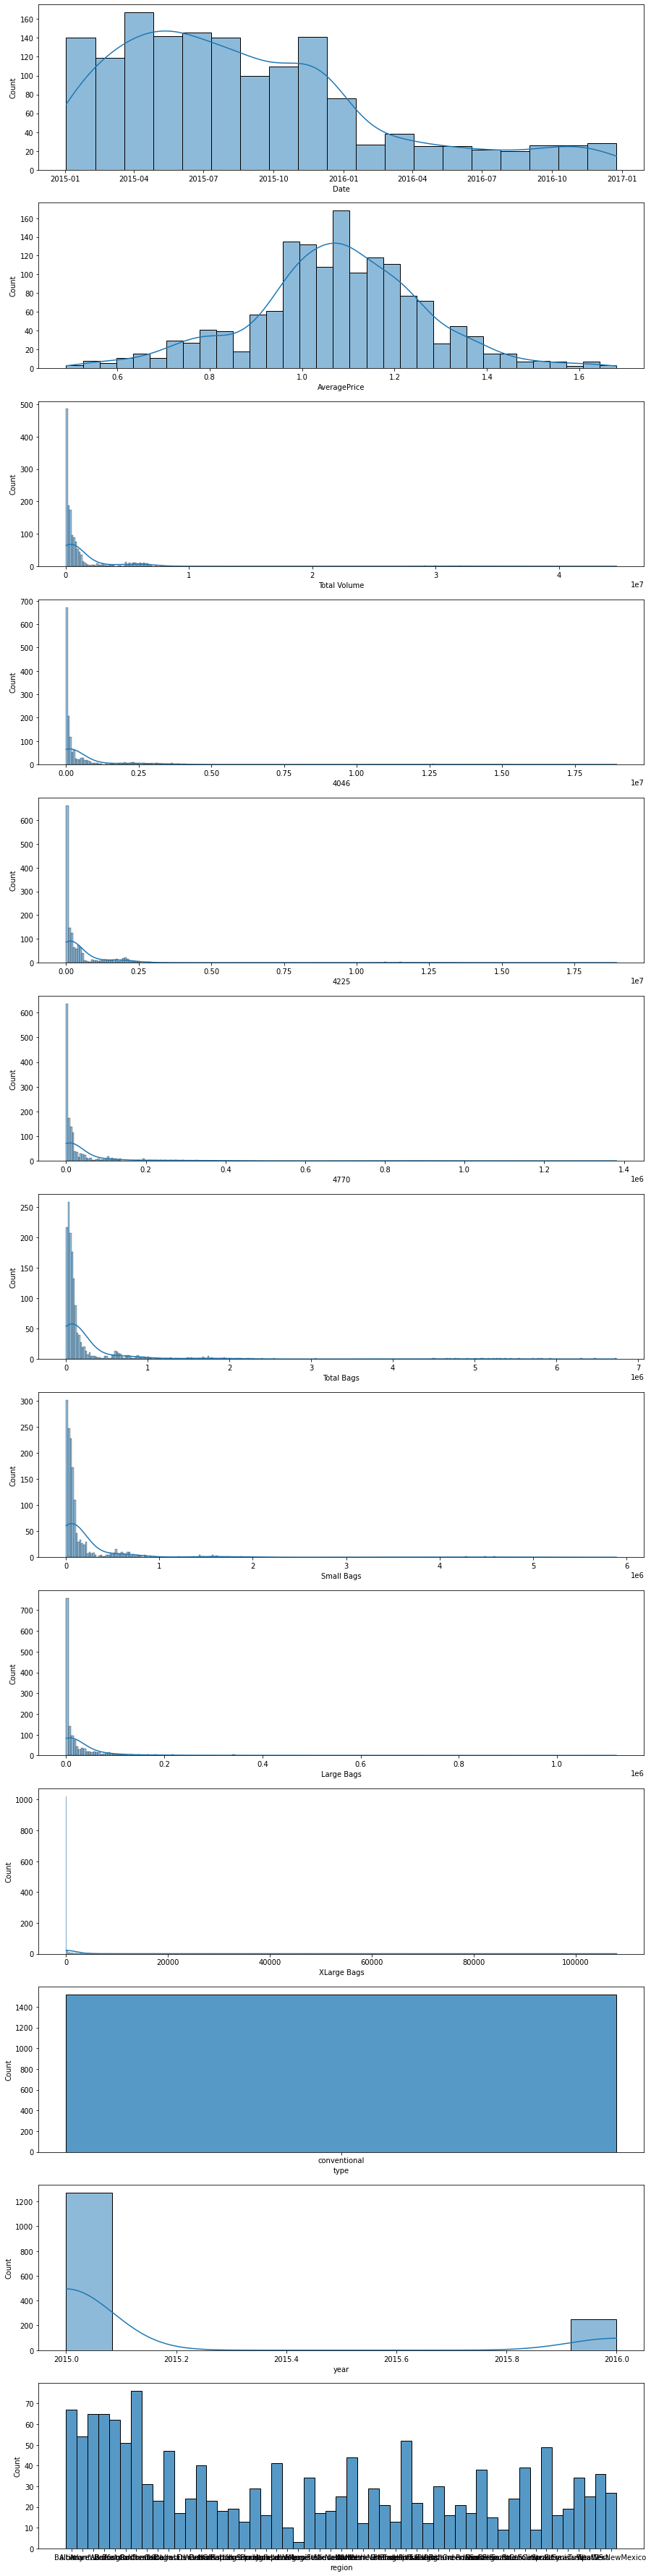

In [14]:
plt.figure(figsize=[15,100])
for i,column_data in enumerate(df.dtypes.items()):
    column, dtype = column_data
    plt.subplot(20,1,i+1)
    if dtype == 'object':
        sns.histplot(df[column])
    else:
        sns.histplot(df[column],kde=True)

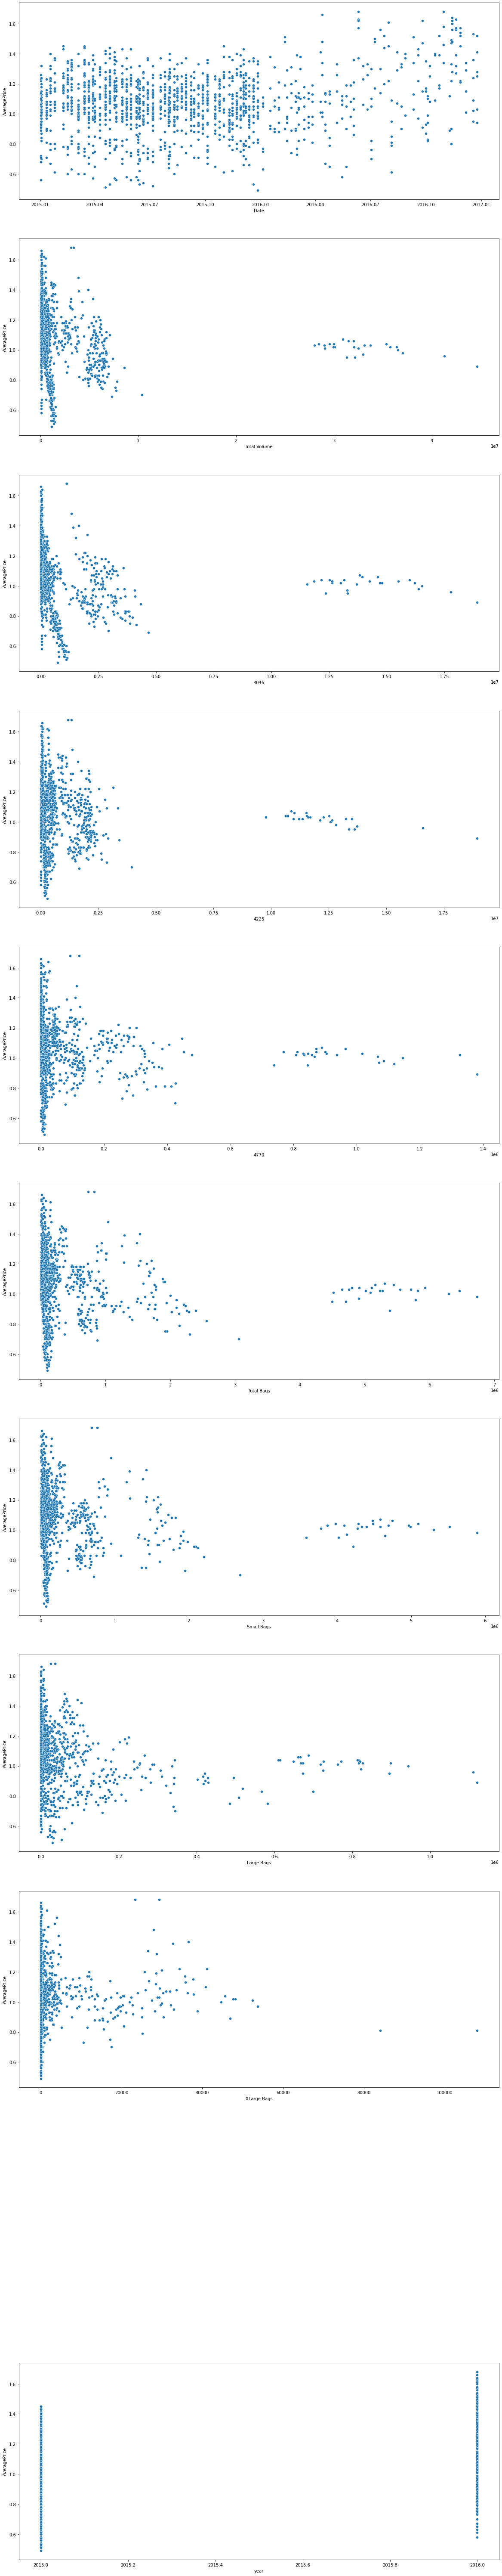

In [15]:
plt.figure(figsize=(20,200))
j = 0
for column, dtype in df.drop(['AveragePrice'],axis=1).dtypes.items():
    j += 1
    if dtype != 'object':
        plt.subplot(20,1,j)
        sns.scatterplot(df[column],df['AveragePrice'])

# Lable Encoder

In [16]:
df = df.apply(LabelEncoder().fit_transform)

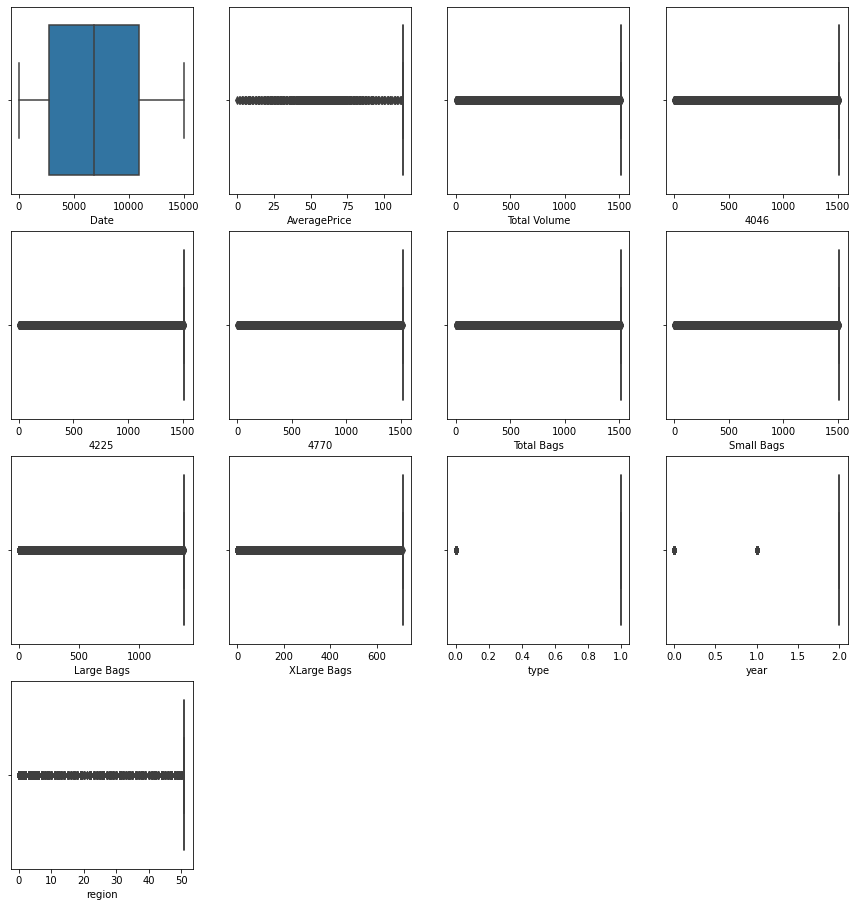

In [17]:
plt.figure(figsize=[15,20])
for i , column in enumerate(df.columns):
    plt.subplot(5,4,i+1)
    sns.boxplot(df[column])

# Remoivng Outliers

In [18]:
abs_zscore = stats.zscore(df)
abs_zscore

array([[-1.46768543, -1.51892764, -5.36270111, ..., -3.13936875,
        -3.37165287, -4.86836706],
       [-1.46790023, -1.405161  , -5.50299593, ..., -3.13936875,
        -3.37165287, -4.86836706],
       [-1.46811503, -3.79426043, -4.49365261, ..., -3.13936875,
        -3.37165287, -4.86836706],
       ...,
       [-0.38510487,  0.30133859,  0.27247437, ...,  0.31853537,
         0.31167855,  0.27698603],
       [ 1.26561568,  0.30133859,  0.27247437, ...,  0.31853537,
         0.31167855,  0.27698603],
       [ 1.75492491,  0.30133859,  0.27247437, ...,  0.31853537,
         0.31167855,  0.27698603]])

In [19]:
df[abs_zscore > 3].index

Int64Index([], dtype='int64')

In [20]:
df.drop(df[abs_zscore > 3].index,axis=0,inplace=True)

# Spliting 

In [21]:

X = df.drop('AveragePrice',axis=1)
y = df['AveragePrice']

# VIF

In [22]:
df_info = pd.DataFrame()
df_info['VIF'] = [variance_inflation_factor(X.values,i) for i in range(X.shape[1])]
df_info['columns'] = X.columns
df_info.sort_values('VIF',ascending=False)

,VIF,columns
5,6200.596596,Total Bags
6,4926.329411,Small Bags
1,3192.538441,Total Volume
3,1042.942989,4225
2,743.281090,4046
9,434.134578,type
10,404.400394,year
7,328.256651,Large Bags
4,295.230907,4770
8,170.949719,XLarge Bags


In [23]:
X['Total Volume_Total Bags_Small Bags_diff'] = X['Total Volume'] - X['Total Bags'] - X['Small Bags']
X.drop(['Total Volume', 'Total Bags', 'Small Bags'],axis=1,inplace=True)

df_info = pd.DataFrame()
df_info['VIF'] = [variance_inflation_factor(X.values,i) for i in range(X.shape[1])]
df_info['columns'] = X.columns
df_info.sort_values('VIF',ascending=False)

,VIF,columns
6,399.732497,type
7,376.754523,year
2,288.915349,4225
1,272.153300,4046
3,264.906944,4770
9,211.447544,Total Volume_Total Bags_Small Bags_diff
4,193.536590,Large Bags
5,163.909420,XLarge Bags
8,120.406159,region
0,4.083649,Date


# Skewness

In [24]:
df.skew().abs().sort_values()

Date            0.058980
type            2.821090
year            2.982413
XLarge Bags     3.336490
AveragePrice    3.337994
region          3.737989
Large Bags      3.880278
4770            3.926885
Total Volume    3.927359
4046            3.927359
Total Bags      3.927359
Small Bags      3.927359
4225            3.927359
dtype: float64

In [25]:
X_train,X_test,y_train,y_test = train_test_split(X,y,shuffle=True,random_state=42)

In [26]:
linearRegression = LinearRegression()
linearRegression.fit(X_train,y_train)

LinearRegression()

In [27]:
y_pred = linearRegression.predict(X_test)
mean_absolute_error(y_test,y_pred)

1.122549068465114

In [28]:
mean_squared_error(y_test,y_pred)

22.851899713056508

In [29]:
r2_score(y_test,y_pred)

0.9239615366556926

In [30]:
kFold = KFold(n_splits=10,random_state=42,shuffle=True)
scores = cross_val_score(
    LinearRegression(),
    X,
    y,
    cv=kFold,
    scoring='r2',
    n_jobs=-1
)
print('score: ',np.mean(scores))
print('std: ',np.std(scores))

score:  0.9285960270697672
std:  0.018924545819973982


# ridge

In [31]:
ridge = Ridge()
ridge.fit(X_train,y_train)

Ridge()

In [32]:

y_pred = ridge.predict(X_test)

In [33]:
mean_absolute_error(y_test,y_pred)

1.13442717685914

In [34]:

mean_squared_error(y_test,y_pred)

22.836210700877725

In [35]:
r2_score(y_test,y_pred)

0.9240137409972329

In [36]:
kFold = KFold(n_splits=10,random_state=42,shuffle=True)
scores = cross_val_score(
    Ridge(),
    X,
    y,
    cv=kFold,
    scoring='r2',
    n_jobs=-1
)
print('score: ',np.mean(scores))
print('std: ',np.std(scores))

score:  0.9286134779401859
std:  0.018424214872996576


DecisionTreeRegressor

In [37]:
decisionTreeRegressor = DecisionTreeRegressor()
decisionTreeRegressor.fit(X_train,y_train)
y_pred = decisionTreeRegressor.predict(X_test)

mean_absolute_error(y_test,y_pred)

0.7937818800097158

In [38]:
mean_squared_error(y_test,y_pred)

15.830944862764149

In [39]:
r2_score(y_test,y_pred)

0.9473233851115987


CV

In [40]:
kFold = KFold(n_splits=10,random_state=42,shuffle=True)
scores = cross_val_score(
    DecisionTreeRegressor(),
    X,
    y,
    cv=kFold,
    scoring='r2',
    n_jobs=-1
)
print('score: ',np.mean(scores))
print('std: ',np.std(scores))

score:  0.9600876517584618
std:  0.012237239895900164


KNeighborsRegressor

In [41]:
kNeighborsRegressor = KNeighborsRegressor()
kNeighborsRegressor.fit(X_train,y_train)
y_pred = kNeighborsRegressor.predict(X_test)
mean_absolute_error(y_test,y_pred)

0.5973281515666747

In [42]:
mean_squared_error(y_test,y_pred)

6.957609910128734

In [44]:
r2_score(y_test,y_pred)

0.9768489284147768


CV

In [45]:
kFold = KFold(n_splits=10,random_state=42,shuffle=True)
scores = cross_val_score(
    KNeighborsRegressor(),
    X,
    y,
    cv=kFold,
    scoring='r2',
    n_jobs=-1
)
print('score: ',np.mean(scores))
print('std: ',np.std(scores))

score:  0.9773142276199618
std:  0.004984233732003693


In [46]:
xGBRegressor = XGBRegressor()

In [47]:
xGBRegressor.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [48]:
y_pred = xGBRegressor.predict(X_test)

In [49]:
mean_absolute_error(y_test,y_pred)

0.5975334050732386

In [50]:
mean_squared_error(y_test,y_pred)

7.469600667285365

In [51]:

r2_score(y_test,y_pred)

0.9751453067942759

CV

In [52]:
kFold = KFold(n_splits=10,random_state=42,shuffle=True)
scores = cross_val_score(
    XGBRegressor(),
    X,
    y,
    cv=kFold,
    scoring='r2',
    n_jobs=-1
)
print('score: ',np.mean(scores))
print('std: ',np.std(scores))

score:  0.9782844930043245
std:  0.005113193405949313


# GridSearchCV for XGBRegressor

In [53]:
param_grid = {
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'n_estimators' : [100, 200],
}
gridSearchCV = GridSearchCV(XGBRegressor(),param_grid=param_grid,n_jobs=-1)

In [54]:
gridSearchCV.fit(X_train,y_train)

GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    enable_categorical=False, gamma=None,
                                    gpu_id=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, predictor=None,
                                    random_state=None, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
                          

In [56]:
gridSearchCV.best_score_

0.9755273202526569

In [55]:
gridSearchCV.best_params_

{'learning_rate': 0.1,
 'max_depth': 7,
 'min_child_weight': 3,
 'n_estimators': 200}

In [58]:

xGBRegressor = XGBRegressor(
        learning_rate = 0.1,
        max_depth = 7,
        min_child_weight = 3,
        n_estimators =200
    )

In [59]:
xGBRegressor.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=7, min_child_weight=3, missing=nan,
             monotone_constraints='()', n_estimators=200, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [60]:
y_pred = xGBRegressor.predict(X_test)

In [61]:

mean_absolute_error(y_test,y_pred)

0.5613548273249162

In [62]:
mean_squared_error(y_test,y_pred)

6.361794997043006

In [63]:
r2_score(y_test,y_pred)

0.978831470391485

# Saving the model

In [64]:
pickle.dump(xGBRegressor,open('xGBRegressor.pkl','wb'))